<img src="files/missionlogo.png">

# Intro to Working with ICESat-2 Data: MGL
The majority of learning resources featured in notebook come from the 2020 ICESat-2 Cryospheric Hackweek
2020 Hackweek Learning Resources GitHub: https://github.com/ICESAT-2HackWeek/learning-resources

### Authors
- Anna Valentine (annavalentine@mymail.mines.edu)
- Countless contributors of code from the Hackweek GitHub Repository



## ICESat-2 Mission: Satellite, Sensor, and Data
There's a lot of information out there to help us better understand the data we are looking at, and a quick google search of ICESat-2 will bring you a lot of information!




Some ICESat-2 websites to familiarize yourself with: 
- National Snow and Ice Data Center: https://nsidc.org/data/icesat-2 
- NASA:  https://icesat-2.gsfc.nasa.gov/

#### Hackweek Tutorial (~1hr) : https://www.youtube.com/watch?v=0guml7ihfdA 

In [1]:
from IPython.display import HTML
from IPython.display import Image

#Ignore warnings that come up with this link 
import warnings
warnings.filterwarnings("ignore", category=UserWarning) 

# Youtube
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/0guml7ihfdA" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

## Common Tools

Most people working with this data will use these basic tools to organize code, analyze, etc.:
- Python 
- GitHub  
- Jupyter Notebook



### Python 
Python is an interpreted, high-level, general-purpose programming language. It is the most commonly used language for looking at this kind of data, and the tools used to help with acessing/analyze data (captoolkit/icepyx) are written in python. It is also reccomended to use Anaconda, which is the recommended Python distribution, for installing and working with Python on your local computer. Conda is an open source package and environment management system for installing multiple versions of software packages, their dependencies and switching easily between them. While you can set up python without anaconda, conda makes it easier to install packages such as numpy, pandas, geopandas and other tools used in data analysis. 

Installation Instructions: https://icesat-2hackweek.github.io/learning-resources/preliminary/conda/ 

### Useful Packages (Python Libraries):
- matplotlib
- gdal
- h5py
- numpy
- pyproj
- icepyx

#### Installing with Conda:
1. Open an anaconda prompt (similar to a command line propmpt)
2. `conda install pckg-name`

*If you are having difficulty installing packages, look at documentation of said package, there may be other dependencies

<img src="files/installmeme.jpg">

### GitHub/Git
Git is a popular version control system that is the foundation of most open source software development. GitHub is a hosting service for Git repositories, enabling us to share code across teams in a web environment. Once set-up, it's a good idea to ask your team if they have a GitHub team or repository that they will work from!

- Make a GitHub Account: https://github.com/ 

- Install Git: https://git-scm.com/

- Join the Mines Glaciology Lab GitHub: 


#### IS2 Git/GitHub Tutorial: https://www.youtube.com/watch?v=O2lLC_s_d20&feature=youtu.be 



# Example Code

In [2]:
#Some of the libraries we need to import
import icepyx as ipx 
import os
import shutil
from pprint import pprint

# utility modules
import glob
import sys
import re

# the usual suspects:
import numpy as np
import matplotlib.pyplot as plt

# specialty modules
import h5py
import pyproj
%matplotlib inline

#Some setup code
path = './download'

## Accessing Data using Icepyx

In [7]:
#First, we need to define where we want to look:
# Pine Island Glacier
short_name = 'ATL06'                           #The data product, as described in data products chart 
spatial_extent = [-102, -76, -98, -74.5]       #Bounding box given in decimal degrees: lower left longitude, 
                                               #lower left latitude, upper right longitude, and upper right latitude.
date_range = ['2019-01-01','2019-03-25']       #Finally, our date range we want to look at 


region_a = ipx.Query(short_name, spatial_extent, date_range)  #We are defining the region we want data for

earthdata_uid = 'annavalentine'                #Put your Earthdata login info here
email = 'annavalentine@mymail.mines.edu'
region_a.earthdata_login(earthdata_uid, email)


Earthdata Login password: ········
['Invalid username or password, please retry.']
Please re-enter your Earthdata user ID: Okemo109!
Earthdata Login password: ········
['Invalid username or password, please retry.']
Please re-enter your Earthdata user ID: annavalentine
Earthdata Login password: ········


In [ ]:
# And now we are going to download our "granules", these will end up in your ./downloads path
region_a.download_granules(path)

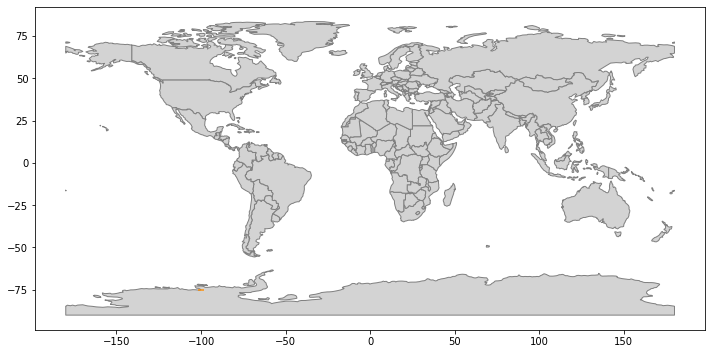

In [8]:
#Okay, but what am I even looking at? Let's use a tool from the icepyx library that easily allows us to see the spacial 
#extent of what we are looking at. Check out the lower left of map in orange!
region_a.visualize_spatial_extent() 

## Data Products & Types
ICESat-2 has many different data products, a quick summary:
- ATL03 : Terrain Elv. 
- ATL04: Lidar Backscatter
- ATL06: Glacier/Ice Sheet Elv. 
- ATL07: Sea Ice Elv. 

FULL TABLE HERE: https://nsidc.org/data/icesat-2/data-sets 

Once you know the dataset you are working with, check out it's data dictionary:

<img src="files/ATL06.jpg">

In [6]:
#ATL06 Reader:
#There are many different ATL06 readers, this is one I have been using, it puts the data into a dictionary 
#However, depending on what you are doing, you may need a reader more simple/comlex. 

def atl06_to_dict(filename, beam, field_dict=None, index=None, epsg=None):
    """
        Read selected datasets from an ATL06 file

        Input arguments:
            filename: ATl06 file to read
            beam: a string specifying which beam is to be read (ex: gt1l, gt1r, gt2l, etc)
            field_dict: A dictinary describing the fields to be read
                    keys give the group names to be read, 
                    entries are lists of datasets within the groups
            index: which entries in each field to read
            epsg: an EPSG code specifying a projection (see www.epsg.org).  Good choices are:
                for Greenland, 3413 (polar stereographic projection, with Greenland along the Y axis)
                for Antarctica, 3031 (polar stereographic projection, centered on the Pouth Pole)
        Output argument:
            D6: dictionary containing ATL06 data.  Each dataset in 
                dataset_dict has its own entry in D6.  Each dataset 
                in D6 contains a numpy array containing the 
                data
    """
    if field_dict is None:
        field_dict={None:['latitude','longitude','h_li', 'atl06_quality_summary'],\
                    'ground_track':['x_atc','y_atc'],\
                    'fit_statistics':['dh_fit_dx', 'dh_fit_dy']}
    D={}
    file_re=re.compile('ATL06_(?P<date>\d+)_(?P<rgt>\d\d\d\d)(?P<cycle>\d\d)(?P<region>\d\d)_(?P<release>\d\d\d)_(?P<version>\d\d).h5')
    with h5py.File(filename,'r') as h5f:
        for key in field_dict:
            for ds in field_dict[key]:
                if key is not None:
                    ds_name=beam+'/land_ice_segments/'+key+'/'+ds
                else:
                    ds_name=beam+'/land_ice_segments/'+ds
                if index is not None:
                    D[ds]=np.array(h5f[ds_name][index])
                else:
                    D[ds]=np.array(h5f[ds_name])
                if '_FillValue' in h5f[ds_name].attrs:
                    bad_vals=D[ds]==h5f[ds_name].attrs['_FillValue']
                    D[ds]=D[ds].astype(float)
                    D[ds][bad_vals]=np.NaN
    if epsg is not None:
        xy=np.array(pyproj.proj.Proj(epsg)(D['longitude'], D['latitude']))
        D['x']=xy[0,:].reshape(D['latitude'].shape)
        D['y']=xy[1,:].reshape(D['latitude'].shape)
    temp=file_re.search(filename)
    D['rgt']=int(temp['rgt'])
    D['cycle']=int(temp['cycle'])
    D['beam']=beam
    return D

## Quick Visualizations of Data
Okay, now I have data, I know what it is (in ATL06's case: derived ice sheet elevations), how can I use it?

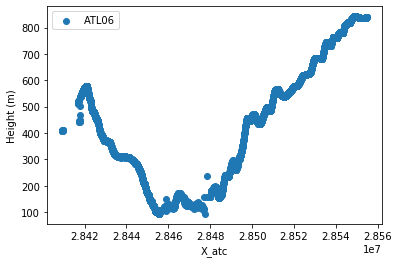

In [10]:
path = './download/*.h5' #Earlier in this code, we downloaded some granules and sent them to this path

ATL06_files = glob.glob(path)  #Glob is a way to get a file list from a path

#Let's look at just one file first, using our ATL06 reader
D6 = atl06_to_dict(ATL06_files[1],'/gt1l', index=None, epsg=3031)   

# We are going to plot the elevations! 
plt.scatter(D6['x_atc'], D6['h_li'], label='ATL06')
plt.xlabel("X_atc")
plt.ylabel("Height (m)")
plt.legend()

Text(0, 0.5, 'y (m)')

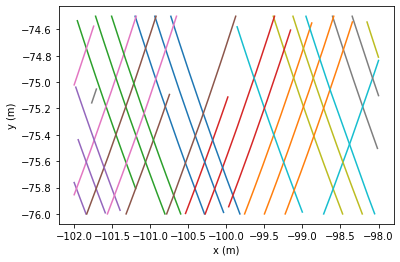

In [12]:
#Okay, how about if we look at multiple files at once, by plotting just long and lat, we can see their crossovers!

for fname in ATL06_files:
    D7 = atl06_to_dict(fname,'/gt2l', index=None, epsg=3031)
    lat = D7['latitude']
    lon = D7['longitude']
    plt.plot(lon, lat)
   
    
plt.xlabel('x (m)')
plt.ylabel('y (m)')


<IPython.core.display.Javascript object>


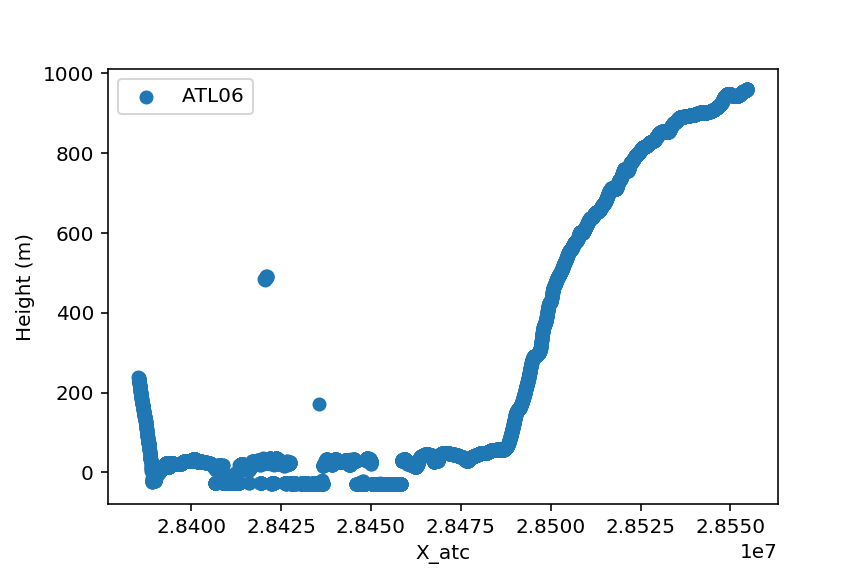

In [19]:
# One particularly useful feature in matplotlib is being able to make your plot interactive,
#especially for looking at data loss:

%matplotlib notebook  

bad_track = atl06_to_dict(ATL06_files[6],'/gt1l', index=None, epsg=3031)   

# We are going to plot the elevations! 
plt.scatter(bad_track['x_atc'], bad_track['h_li'], label='ATL06')
plt.xlabel("X_atc")
plt.ylabel("Height (m)")
plt.legend()

#Look at how weird this track is.....something to think about! 

## More Example Notebooks : 
- ICESat-2 Hackweek Tutorials: https://github.com/ICESAT-2HackWeek/2020_ICESat-2_Hackweek_Tutorials
- Icepyx Tutorials: https://github.com/icesat2py/icepyx/tree/development/examples
- Anna's Repo of Random Code: 